<center><h1> - Projet S5 -  </h1> </center>
</p>
<center><h3>Classification, appariement et segmentation de masses en mammographies multi-vues par deep learning </h3></center> 

<center><i> Predict results</i> </center>

#Mount drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd drive/My\ Drive/projectS5

/content/drive/My Drive/projectS5


#Import and download libraries

In [3]:
!pip install einops

In [4]:
!pip install pytorch_lightning

     |████████████████████████████████| 686kB 8.0MB/s 
     |████████████████████████████████| 102kB 11.2MB/s 
     |████████████████████████████████| 645kB 13.9MB/s 
     |████████████████████████████████| 829kB 25.6MB/s 
     |████████████████████████████████| 1.3MB 32.9MB/s 
     |████████████████████████████████| 296kB 53.4MB/s 
     |████████████████████████████████| 143kB 49.9MB/s 
  Created wheel for future: filename=future-0.18.2-cp36-none-any.whl size=491057 sha256=4b96e1b937af5b574217f59b2d23b5d932af4ed9da3073c2f896ec912811f1c4
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
  Created wheel for idna-ssl: filename=idna_ssl-1.1.0-cp36-none-any.whl size=3163 sha256=866b6b0c5c33a2ebc94c6b4e779874f7269a2b2f696e36cf7e8e0313cf66020e
  Stored in directory: /root/.cache/pip/wheels/d3/00/b3/32d613e19e08a739751dd6bf998cfed277728f8b2127ad4eb7
Successfully built future idna-ssl
  Found existing installation: PyYAML 3.13
    Uninst

In [5]:
import os
import numpy as np
from tqdm import tqdm
import config as cfg
from data.datamodule import DataModule
from lightningModel import LightningModel
import matplotlib.pyplot as plt
from einops import rearrange
import torchvision.transforms as transforms


#Useful Functions

In [6]:
def dice_score(outputs, targets, ratio=0.5):
    outputs = outputs.flatten()
    targets = targets.flatten()
    outputs[outputs > ratio] = np.float32(1)
    outputs[outputs < ratio] = np.float32(0)    
    return float(2 * (targets * outputs).sum())/float(targets.sum() + outputs.sum())

def plot_images(arrays_list,legends_list = None,cmap = 'gray', colorbar=False, title = None):
    if legends_list is not None:
      assert len(arrays_list) == len(legends_list), 'arrays_list and legends_list must have same size' 
    plt.figure(figsize=(20, 15))

    for i in range(len(arrays_list)):
        plt.subplot(1, len(arrays_list), i+1)
        if arrays_list[i].shape[0] == 3: # image
            image_array = rearrange(arrays_list[i], 'c h w -> h w c')
        else:
            image_array = arrays_list[i].squeeze(0)
        plt.imshow(image_array, cmap=cmap)
        plt.axis('off')
        if legends_list is not None:
          plt.title(legends_list[i])
        if colorbar:
            plt.colorbar(shrink=(1/len(arrays_list)))
    if title is not None:
      plt.suptitle(title)
      
    plt.show()

inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
    std=[1/0.229, 1/0.224, 1/0.255]
)


#I/ Predict on training set

In [ ]:
ROOT_DIR = "lightning_logs/INbreast_multi_tache/checkpoints"
checkpoints = sorted(list(map(lambda x: os.path.join(ROOT_DIR, x), os.listdir(ROOT_DIR))))
models = {}
for i, checkpoint in tqdm(enumerate(checkpoints[:1])):
    models[i] = LightningModel.load_from_checkpoint(checkpoint)

1it [00:02,  2.03s/it]


In [ ]:
datamodule_config = cfg.DataModule()
datamodule = DataModule.from_config(datamodule_config)
datamodule.setup(stage='train')
img_cc, img_mlo, gt_cls_cc, gt_cls_mlo, gt_mat, mask_cc,mask_mlo = next(iter(datamodule.train_dataloader()))

In [ ]:
img_cc, img_mlo = img_cc, img_mlo#.cuda()
mask_cc, mask_mlo = mask_cc, mask_mlo#.cuda()
model = models[0]#.cuda()
model = model.eval()

outputs = model(img_cc, img_mlo)

img_cc_array, img_mlo_array = img_cc.cpu().detach().numpy(), img_mlo.cpu().detach().numpy()
target_cc, target_mlo  = mask_cc.cpu().detach().numpy(),mask_mlo.cpu().detach().numpy()
output_cc, output_mlo  =  outputs[2].cpu().detach().numpy(),outputs[-1].cpu().detach().numpy()

In [ ]:
output_cc[output_cc > 0.5] = 1
output_cc[output_cc < 0.5] = 0

output_mlo[output_mlo < 0.5] = 0
output_mlo[output_mlo > 0.5] = 1

In [ ]:
inv_cc = inv_normalize(img_cc)
inv_cc_array = inv_cc.cpu().detach().numpy()
inv_mlo = inv_normalize(img_mlo)
inv_mlo_array = inv_mlo.cpu().detach().numpy()

In [ ]:
idx = 34

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


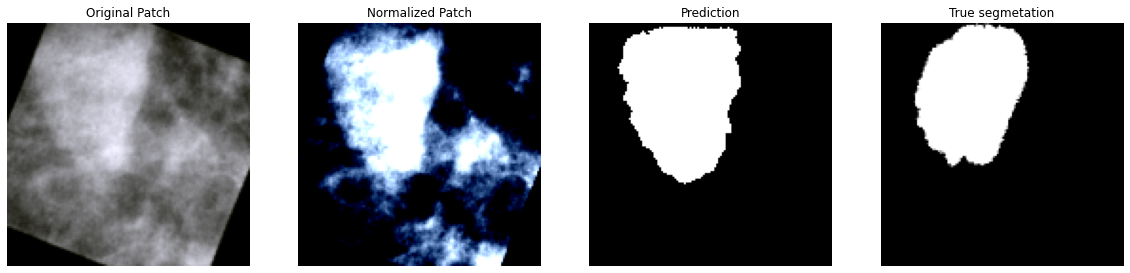

In [ ]:
plot_images([inv_cc_array[idx], img_cc_array[idx],output_cc[idx], target_cc[idx]],['Original Patch', 'Normalized Patch', 'Prediction', 'True segmetation'], cmap = 'gray')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


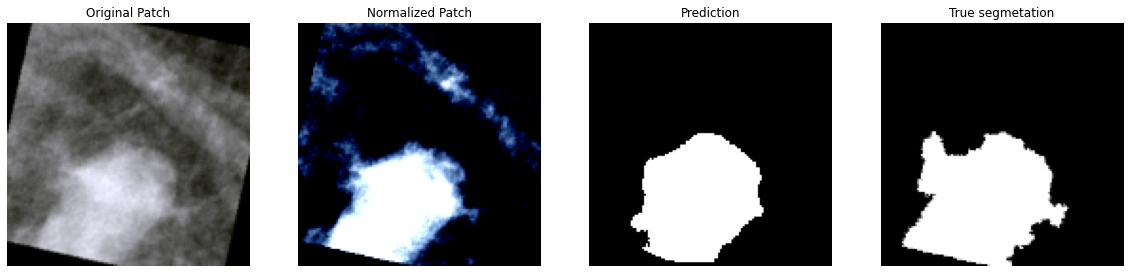

In [ ]:
plot_images([inv_mlo_array[idx], img_mlo_array[idx],output_mlo[idx], target_mlo[idx]],['Original Patch', 'Normalized Patch', 'Prediction', 'True segmetation'], cmap = 'gray')

In [ ]:
print('Dice score for CC view : {:.2f}\nDice score for MLO view : {:.2f}'.format(dice_score(output_cc[idx], target_cc[idx]), dice_score(output_mlo[idx],target_mlo[idx])))

Dice score for CC view : 0.87
Dice score for MLO view : 0.89


#II/Predict on validation set
 

In [ ]:
datamodule_config = cfg.DataModule(input_root = 'data/patches-INbreast')
datamodule = DataModule.from_config(datamodule_config)
datamodule.setup(stage = 'val')
img, gt_cls, mask, files = next(iter(datamodule.val_dataloader()))

In [ ]:
img = img#.cuda()
mask = mask#.cuda()
model = models[0]#.cuda()
model = model.eval()
outputs = model(img)

img_array = img.cpu().detach().numpy()
target = mask.cpu().detach().numpy()
output = outputs[-1].cpu().detach().numpy()

test_val = inv_normalize(img)
test_val_array = test_val.cpu().detach().numpy()

output[output > 0.5] = 1
output[output < 0.5] = 0

In [ ]:
idx = 19

In [ ]:
print(files[1][idx])
print(files[0][idx])

data/patches-INbreast/val/mask_val/11488229-RCC-06-mask.png
data/patches-INbreast/val/CC/11488229-RCC-06.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


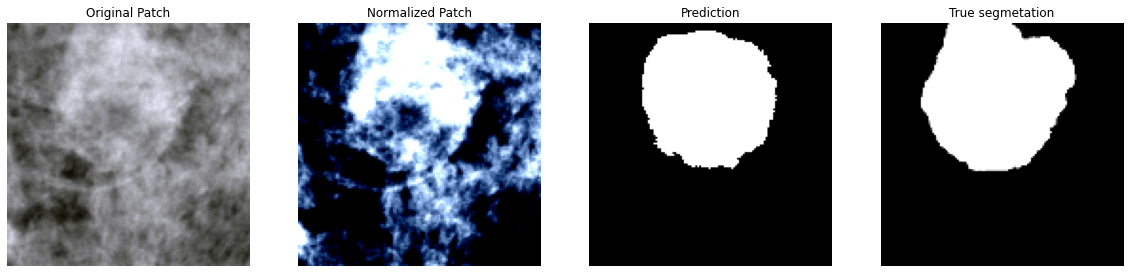

In [ ]:
plot_images([test_val_array[idx], img_array[idx],output[idx], target[idx]],['Original Patch', 'Normalized Patch', 'Prediction', 'True segmetation'], cmap = 'gray')

In [ ]:
print('Dice score : {:.2f}'.format(dice_score(output, target)))

Dice score : 0.71


#III/ Test results

In [10]:
ROOT_DIR = "lightning_logs/version_3/checkpoints"
checkpoints = sorted(list(map(lambda x: os.path.join(ROOT_DIR, x), os.listdir(ROOT_DIR))))
models = {}
for i, checkpoint in tqdm(enumerate(checkpoints[:1])):
    models[i] = LightningModel.load_from_checkpoint(checkpoint)

1it [00:05,  5.43s/it]


In [8]:
from pytorch_lightning import Trainer
datamodule_config = cfg.DataModule(input_root = 'data/patches-DDSM-CBIS')
datamodule = DataModule.from_config(datamodule_config)
model = models[0]
trainer = Trainer(gpus = 1)
trainer.test(model, datamodule.test_dataloader())



/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: You have set progress_bar_refresh_rate < 20 on Google Colab. This may crash. Consider using progress_bar_refresh_rate >= 20 in Trainer.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'Test/accuracy': tensor(0.8903), 'Test/dice': tensor(0.0036)}
--------------------------------------------------------------------------------


[{'Test/accuracy': 0.8903490900993347, 'Test/dice': 0.0036099748685956}]

In [11]:
from pytorch_lightning import Trainer
datamodule_config = cfg.DataModule(input_root = 'data/patches-INbreast')
datamodule = DataModule.from_config(datamodule_config)
model = models[0]
trainer = Trainer(gpus = 1)
trainer.test(model, datamodule.test_dataloader())


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: You have set progress_bar_refresh_rate < 20 on Google Colab. This may crash. Consider using progress_bar_refresh_rate >= 20 in Trainer.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'Test/accuracy': tensor(0.8986), 'Test/dice': tensor(0.0085)}
--------------------------------------------------------------------------------


[{'Test/accuracy': 0.8986014127731323, 'Test/dice': 0.00852128304541111}]

In [11]:
model = models[0]
datamodule_config = cfg.DataModule(input_root = 'data/patches-DDSM-CBIS')
datamodule = DataModule.from_config(datamodule_config)
trainer = Trainer(gpus = 1)
trainer.test(model, datamodule.test_dataloader())

/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: You have set progress_bar_refresh_rate < 20 on Google Colab. This may crash. Consider using progress_bar_refresh_rate >= 20 in Trainer.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'Test/accuracy': tensor(0.8986), 'Test/dice': tensor(0.6872)}
--------------------------------------------------------------------------------


[{'Test/accuracy': 0.8985626101493835, 'Test/dice': 0.6871846914291382}]

In [14]:
from pytorch_lightning import Trainer

model = models[0]
datamodule_config = cfg.DataModule(input_root = 'data/patches-INbreast')
datamodule = DataModule.from_config(datamodule_config)
trainer = Trainer(gpus = 1)
trainer.test(model, datamodule.test_dataloader())

/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: You have set progress_bar_refresh_rate < 20 on Google Colab. This may crash. Consider using progress_bar_refresh_rate >= 20 in Trainer.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'Test/accuracy': tensor(0.9105), 'Test/dice': tensor(0.6807)}
--------------------------------------------------------------------------------


[{'Test/accuracy': 0.9104894995689392, 'Test/dice': 0.6806560754776001}]